In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt




In [2]:
# --- When to Use DBSCAN and Data Requirements ---
# DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a powerful clustering algorithm.
#
# When to use it:
# - When you have clusters of arbitrary shape (i.e., not just spherical clusters like k-means assumes).
# - When you need to identify noise or outliers in your data. DBSCAN automatically labels points that don't belong to any cluster as noise.
# - When you don't know the number of clusters beforehand. DBSCAN determines the number of clusters based on the data's density.
#
# Data Requirements:
# - DBSCAN is sensitive to the scale of the data. It's highly recommended to scale your features before applying the algorithm.
#   Techniques like StandardScaler are commonly used.
# - The performance of DBSCAN depends on two key hyperparameters: `eps` (the maximum distance between two samples for one to be considered as in the neighborhood of the other)
#   and `min_samples` (the number of samples in a neighborhood for a point to be considered as a core point).
#   Choosing these parameters can be challenging and often requires domain knowledge or experimentation (like the grid search below).



In [3]:
# 1. Load a relevant sample dataset
# We'll use the famous Iris dataset, which contains measurements for three species of iris flowers.
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
print("Original Iris Dataset Head:")
print(iris_df.head())
print("\n")



Original Iris Dataset Head:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2




In [4]:
# 2. Select features and scale them
# We will use 'sepal width (cm)' and 'petal width (cm)' for this demonstration.
# As required by DBSCAN, we will scale the features.
features = ['sepal width (cm)', 'petal width (cm)']
X = iris_df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [5]:
# 3. Hyperparameter Tuning (Manual Grid Search)
# We will test different combinations of `eps` and `min_samples` to see how they affect the clustering result.
# The goal is to find a combination that identifies a reasonable number of clusters and noise points.

eps_values = [0.2, 0.3, 0.4, 0.5]
min_samples_values = [3, 5, 7, 10]

tuning_results = []

print("--- Starting Hyperparameter Tuning ---")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_scaled)

        # Count the number of clusters found (ignoring noise, which is labeled -1)
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        # Count the number of noise points
        n_noise = np.sum(np.array(clusters) == -1)

        tuning_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise
        })

results_df = pd.DataFrame(tuning_results)
print("Hyperparameter Tuning Results:")
print(results_df)
print("\n")




--- Starting Hyperparameter Tuning ---
Hyperparameter Tuning Results:
    eps  min_samples  n_clusters  n_noise
0   0.2            3          18       54
1   0.2            5           8       92
2   0.2            7           2      134
3   0.2           10           0      150
4   0.3            3           4       12
5   0.3            5           2       24
6   0.3            7           2       29
7   0.3           10           3       55
8   0.4            3           2        7
9   0.4            5           2        9
10  0.4            7           2       16
11  0.4           10           2       30
12  0.5            3           2        4
13  0.5            5           2        4
14  0.5            7           2        4
15  0.5           10           2        8




In [6]:
# 4. Apply the final model with chosen hyperparameters
# Based on the results above, let's choose a set of parameters.
# A good choice might be one that gives a reasonable number of clusters (e.g., 2 or 3 for Iris) and a small amount of noise.
# Let's select eps=0.4 and min_samples=5 for this example.
best_eps = 0.4
best_min_samples = 5


final_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples,)
final_clusters = final_dbscan.fit_predict(X_scaled)

# Add the cluster labels to our original DataFrame
iris_df['cluster'] = final_clusters




In [7]:
# 5. Show the result of applying the technique
# For clustering, a visualization is one of the best ways to see the result.
# We will also identify and display the noise points (outliers).

# Create a new DataFrame for outliers (noise points are labeled -1)
outliers_df = iris_df[iris_df['cluster'] == -1].copy()

# In DBSCAN, there isn't a direct "outlier score" like in other methods.
# The label of -1 itself signifies that the point is an outlier/noise.
# We can add a column to explicitly state this.
outliers_df['outlier_status'] = 'Noise'

print("--- Final Model Applied ---")
print(f"Chosen Parameters: eps={best_eps}, min_samples={best_min_samples}")
print("\nHead of DataFrame with Cluster Labels:")
print(iris_df.head())

print("\nIdentified Outliers (Noise Points):")
print(outliers_df)




--- Final Model Applied ---
Chosen Parameters: eps=0.4, min_samples=5

Head of DataFrame with Cluster Labels:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   cluster  
0        0  
1        0  
2        0  
3        0  
4        0  

Identified Outliers (Noise Points):
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
15                 5.7               4.4                1.5               0.4   
32                 5.2               4.1                1.5               0.1   
33                 5.5               4.2                1

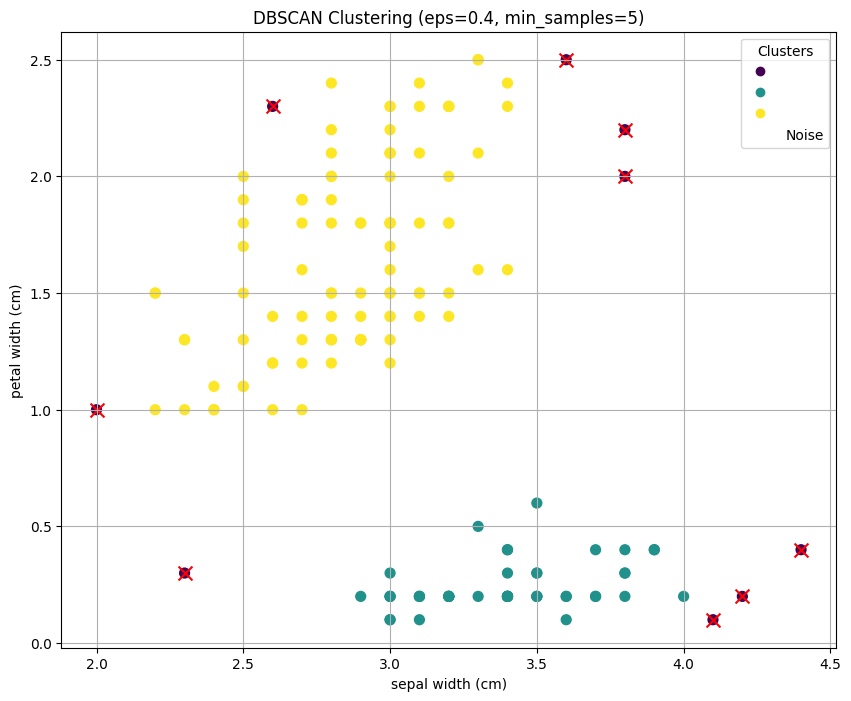

In [8]:
# 6. Visualize the clustering result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(iris_df[features[0]], iris_df[features[1]], c=iris_df['cluster'], cmap='viridis', s=50)

# Highlight the noise points
noise_points = iris_df[iris_df['cluster'] == -1]
plt.scatter(noise_points[features[0]], noise_points[features[1]], c='red', marker='x', s=100, label='Noise')

plt.title(f'DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})')
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend(handles=scatter.legend_elements()[0] + [plt.Line2D([0], [0], marker='x', color='w', label='Noise', markerfacecolor='red', markersize=10)],
           title="Clusters")
plt.grid(True)
plt.show()